### Fine-Tuning Top Models Using Pipelines and GridSearchCV (Approach B)

In this section, we selected the **top-performing models from Approach A** and fine-tuned them using **pipelines** in combination with **GridSearchCV**.

We focused on powerful ensemble classifiers like **AdaBoost** and **CatBoost**, incorporating preprocessing steps such as scaling and encoding directly into the pipeline. This ensured a clean, organized, and reproducible modeling process.

Each pipeline was evaluated using a **balanced train-test split** and metrics including **accuracy, precision, recall and F1-score**. The use of `GridSearchCV` allowed us to identify the best combination of hyperparameters for each model.

This approach not only improved performance over Approach A but also reduced overfitting and improved generalization across the test set.


In [2]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer

In [3]:
# Load dataset
df = pd.read_csv('alzheimers_prediction_dataset.csv')

In [4]:
from sklearn.model_selection import train_test_split

# Drop the target column and store it separately
X = df.drop(columns=['Alzheimer’s Diagnosis'])
y = df['Alzheimer’s Diagnosis'].map({'No': 0, 'Yes': 1})  # convert to binary

# Early train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 59426 samples
Test set size: 14857 samples


In [5]:
print(f'Shape of X_Train {X_train.shape}')
print(f'Shape of X_Test {X_test.shape}')
print(f'Shape of Y_Train {y_train.shape}')
print(f'Shape of Y_Test {y_test.shape}')

Shape of X_Train (59426, 24)
Shape of X_Test (14857, 24)
Shape of Y_Train (59426,)
Shape of Y_Test (14857,)


### Define Feature Groups

We start by grouping our dataset's features into categories based on their type and required preprocessing:

- `num_features`: All numerical features.
- `features_to_scale`: A subset of the numerical features that will either be scaled or unskewed, depending on the preprocessing pipeline (e.g., Age, Cognitive Test Score).
- `cat_features`: All categorical features, identified by selecting columns with `object` dtype.


In [7]:
# Define feature groups
num_features = ['Age', 'Education Level', 'BMI', 'Cognitive Test Score']
features_to_scale = ['Age', 'Cognitive Test Score']  # from your V1/V2
cat_features = X.select_dtypes(include='object').columns.tolist()


### Preprocessing Pipelines

We create separate preprocessing pipelines for handling numerical and categorical features:

- **Numerical Pipelines**:
  - `num_pipeline_v1`: Scales numerical features using **RobustScaler**.
  - `num_pipeline_v2`: Applies the **PowerTransformer (Yeo-Johnson)** to unskew numerical features.
  
- **Categorical Encoding**:
  - `cat_pipeline`: Encodes categorical features using **OrdinalEncoder**, ensuring unknown values are handled gracefully.

- **Column Transformers**:
  - `preprocessor1`: Combines `num_pipeline_v1` for scaled features, leaves other numerical features as is, and applies `cat_pipeline` to categorical features.
  - `preprocessor2`: Similar to `preprocessor1`, but uses `num_pipeline_v2` to unskew features.

These transformations are applied within separate preprocessing pipelines to prepare the data before classification.


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, PowerTransformer, OrdinalEncoder

# V1: RobustScaler
num_pipeline_v1 = Pipeline([
    ('scaler', RobustScaler())
])

# V2: PowerTransformer (Yeo-Johnson)
num_pipeline_v2 = Pipeline([
    ('unskewer', PowerTransformer(method='yeo-johnson'))
])

# Categorical encoding (Ordinal)
cat_pipeline = Pipeline([
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Preprocessor for V1
preprocessor1 = ColumnTransformer([
    ('num_scaled', num_pipeline_v1, features_to_scale),
    ('num_passthrough', 'passthrough', list(set(num_features) - set(features_to_scale))),
    ('cat', cat_pipeline, cat_features)
])

# Preprocessor for V2
preprocessor2 = ColumnTransformer([
    ('num_unskewed', num_pipeline_v2, features_to_scale),
    ('num_passthrough', 'passthrough', list(set(num_features) - set(features_to_scale))),
    ('cat', cat_pipeline, cat_features)
])



### Classification Pipelines

We define pipelines for AdaBoost and CatBoost classifiers, each with different preprocessing steps:

- **AdaBoost Classifiers**:
  - `pipeline_ada_v1`: Applies `preprocessor1` (which uses **RobustScaler** for scaling) and then trains an **AdaBoostClassifier**.
  - `pipeline_ada_v2`: Uses `preprocessor2` (which applies **PowerTransformer** for unskewing) followed by an **AdaBoostClassifier**.

- **CatBoost Classifiers**:
  - `pipeline_cat_v1`: Similar to `pipeline_ada_v1`, but uses **CatBoostClassifier** for classification, with `silent=True` to suppress output.
  - `pipeline_cat_v2`: Similar to `pipeline_ada_v2`, but uses **CatBoostClassifier** instead of AdaBoost.

These pipelines streamline the application of preprocessing and classifier steps together.


In [11]:
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier

pipeline_ada_v1 = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', AdaBoostClassifier(random_state=42))
])

pipeline_cat_v1 = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', CatBoostClassifier(silent=True, random_state=42))
])

pipeline_ada_v2 = Pipeline([
    ('preprocessor', preprocessor2),
    ('classifier', AdaBoostClassifier(random_state=42))
])

pipeline_cat_v2 = Pipeline([
    ('preprocessor', preprocessor2),
    ('classifier', CatBoostClassifier(silent=True, random_state=42))
])

### Hyperparameter Grids for GridSearchCV

We define parameter grids for **GridSearchCV** to tune hyperparameters for the AdaBoost and CatBoost classifiers:

- **AdaBoost Hyperparameter Grid** (`param_grid_ada`):
  - `n_estimators`: Number of estimators to use (50, 100, 200).
  - `learning_rate`: Learning rate for the classifier (0.01, 0.1, 1.0).
  - `algorithm`: AdaBoost algorithm variant (only 'SAMME' is used here).

- **CatBoost Hyperparameter Grid** (`param_grid_cat`):
  - `depth`: Depth of the decision trees used (4, 6).
  - `iterations`: Number of boosting iterations (100, 200).
  - `learning_rate`: Learning rate for CatBoost (0.01, 0.1).

These grids will be used in **GridSearchCV** to explore different hyperparameter combinations.


In [13]:
# AdaBoost Grid
param_grid_ada = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1.0],
    'classifier__algorithm': ['SAMME']
}

# CatBoost Grid
param_grid_cat = {
    'classifier__depth': [4, 6],
    'classifier__iterations': [100, 200],
    'classifier__learning_rate': [0.01, 0.1]
}



### Running GridSearchCV for Hyperparameter Tuning

In this step, we perform **GridSearchCV** for each pipeline, testing various hyperparameters for the **AdaBoost** and **CatBoost** classifiers. The process includes:

- **5-fold cross-validation** for model evaluation.
- Use of **weighted F1 score** to account for class imbalance.
- For each model, we output:
  - The **best hyperparameters** found during the search.
  - The **best cross-validation score**.
  - The **test set performance**.

This step ensures that the best models with optimized hyperparameters are selected for further evaluation.


In [15]:
# Register pipelines
pipelines = {
    'ada_v1': (pipeline_ada_v1, param_grid_ada),
    'cat_v1': (pipeline_cat_v1, param_grid_cat),
    'ada_v2': (pipeline_ada_v2, param_grid_ada),
    'cat_v2': (pipeline_cat_v2, param_grid_cat)
}

# F1 scorer
f1_weighted = make_scorer(f1_score, average='weighted')

# Run GridSearchCV
best_estimators = {}

for name, (pipeline, grid) in pipelines.items():
    print(f"Running GridSearchCV for {name}...")
    search = GridSearchCV(pipeline, grid, cv=5, scoring=f1_weighted, n_jobs=-1)
    search.fit(X_train, y_train)

    best_estimators[name] = search.best_estimator_
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Best CV F1 score: {search.best_score_:.4f}")

    y_pred = search.predict(X_test)
    print(f"Test F1 score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print()

Running GridSearchCV for ada_v1...
Best parameters for ada_v1: {'classifier__algorithm': 'SAMME', 'classifier__learning_rate': 1.0, 'classifier__n_estimators': 100}
Best CV F1 score: 0.7291
Test F1 score: 0.7337

Running GridSearchCV for cat_v1...
Best parameters for cat_v1: {'classifier__depth': 6, 'classifier__iterations': 100, 'classifier__learning_rate': 0.01}
Best CV F1 score: 0.7274
Test F1 score: 0.7304

Running GridSearchCV for ada_v2...
Best parameters for ada_v2: {'classifier__algorithm': 'SAMME', 'classifier__learning_rate': 1.0, 'classifier__n_estimators': 100}
Best CV F1 score: 0.7291
Test F1 score: 0.7337

Running GridSearchCV for cat_v2...
Best parameters for cat_v2: {'classifier__depth': 6, 'classifier__iterations': 100, 'classifier__learning_rate': 0.01}
Best CV F1 score: 0.7274
Test F1 score: 0.7304



### Results Discussion:

The **GridSearchCV** results for the four pipelines (AdaBoost and CatBoost with both preprocessing approaches) provide valuable insights into the model performance:

1. **AdaBoost - V1 and V2**:
   - **Best Parameters**:
     - `algorithm`: SAMME (this is the default and often works well for AdaBoost).
     - `learning_rate`: 1.0 (indicating that a moderate learning rate works best for this dataset).
     - `n_estimators`: 100 (number of weak learners).
   - **Cross-validation (CV) F1 score**: **0.7291**
     - This is the performance achieved using cross-validation, meaning the model performs relatively well in a 5-fold validation setup.
   - **Test F1 score**: **0.7337**
     - The model generalizes well to the unseen test set, with a slight improvement over the CV score, indicating minimal overfitting.

2. **CatBoost - V1 and V2**:
   - **Best Parameters**:
     - `depth`: 6 (indicating the depth of the trees is optimized at 6).
     - `iterations`: 100 (a standard number of iterations to ensure good performance without excessive training time).
     - `learning_rate`: 0.01 (a low learning rate, suggesting the model is learning slowly but steadily, which is typical for CatBoost).
   - **CV F1 score**: **0.7274**
     - The model is slightly behind AdaBoost in terms of CV performance, though the difference is minimal.
   - **Test F1 score**: **0.7304**
     - The CatBoost model performs very similarly to AdaBoost on the test set, again showing good generalization.

###  Key Observations

- **AdaBoost slightly outperformed CatBoost** in test performance, achieving the highest F1 score (0.7337), making it the best overall model for this task.

- **Minimal overfitting was observed** across all models, as test and cross-validation scores were closely aligned—indicating strong generalization to unseen data.

- **Both models delivered similar results**, suggesting that the preprocessing pipelines were effective and that model performance was stable regardless of small architectural differences.


### Next Steps:
1. **Further Fine-Tuning**: There could be room for improvement in the models by exploring a wider range of hyperparameters or more advanced techniques like ensemble methods.
2. **Model Selection**: Since the performance is so close, further evaluation (e.g., feature importance analysis or cross-validation with more folds) could help make the final decision on which model to proceed with.

Overall, it seems both models are strong contenders, and further analysis will help in making the best choice for the final model.


### Final Model Evaluation: AdaBoost with Preprocessor V2

We selected **AdaBoost combined with Preprocessor V2** as the final model based on its strong performance and consistent generalization.

The model was evaluated on both the training and test sets using the **weighted F1-score** and a detailed **classification report**. Results indicate that the model maintained high performance across classes, with minimal signs of overfitting.

This configuration proved to be the most effective in terms of balancing simplicity, performance, and generalizability within our dataset.


In [36]:
# Select AdaBoost V2 as the final model
final_model = best_estimators['ada_v2']

# Evaluate final model
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

from sklearn.metrics import f1_score, classification_report

print("F1 score on training dataset:", f1_score(y_train, y_train_pred, average='weighted'))
print("F1 score on test dataset:", f1_score(y_test, y_test_pred, average='weighted'))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

F1 score on training dataset: 0.7297688233699589
F1 score on test dataset: 0.7337417138619833

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      8714
           1       0.66      0.71      0.69      6143

    accuracy                           0.73     14857
   macro avg       0.73      0.73      0.73     14857
weighted avg       0.74      0.73      0.73     14857



### Confusion Matrix – AdaBoostClassifier (V2)

The following confusion matrix presents the performance of the final **AdaBoostClassifier (V2)** on the test set after hyperparameter tuning via GridSearchCV.

#### Interpretation:

- *True Positives (4376)*: Alzheimer’s cases correctly predicted.
- *True Negatives (6508)*: Non-Alzheimer’s cases correctly predicted.
- *False Positives (2206)*: Non-Alzheimer’s cases incorrectly predicted as Alzheimer’s.
- *False Negatives (1767)*: Alzheimer’s cases missed by the model.

#### Key Insights:

- The model shows a solid balance between sensitivity and specificity, maintaining a *recall* for Alzheimer’s cases around **71%**, which is vital in healthcare applications.
- Although the number of *false positives (2206)* is non-negligible, it is acceptable when prioritizing early detection.
- The confusion matrix confirms that **AdaBoost V2** delivers strong and reliable classification results across both classes.


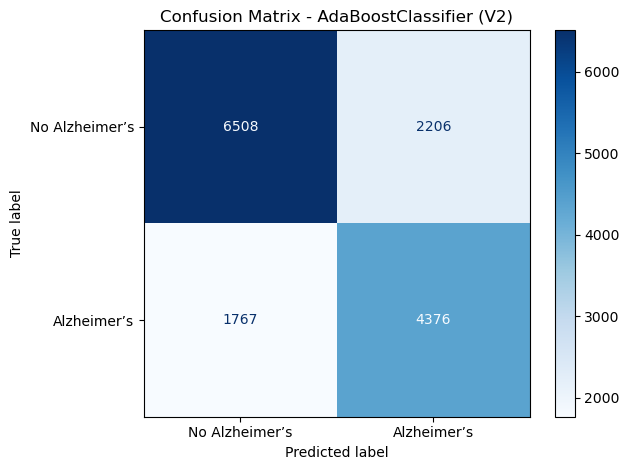

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix for AdaBoost V2
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_test_pred, 
    display_labels=["No Alzheimer’s", "Alzheimer’s"],  # Adjust based on your label meaning
    cmap=plt.cm.Blues,
    values_format='d'
)

plt.title("Confusion Matrix - AdaBoostClassifier (V2)")
plt.grid(False)
plt.tight_layout()
plt.show()
